<a href="https://colab.research.google.com/github/jumbojing/segment-anything/blob/main/notebooks/samDicom_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

- 使用SAM自动生成对象掩码

由于SAM可以有效地处理提示，所以可以通过在图像上对大量提示进行采样来生成用于整个图像的掩模。该方法用于生成数据集SA-1B。

类 SamAutomaticMaskGenerator实现了此功能。它通过在图像上的网格中采样单点输入提示来工作，SAM可以从每个输入提示中预测多个掩码。然后，针对质量对掩模进行滤波，并使用非最大抑制进行去重复。附加选项允许进一步改进掩模质量和数量，例如对图像的多个裁剪或后处理掩模运行预测以去除小的断开区域和孔。

In [17]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/jumbojing/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

如果使用jupyter在本地运行，首先安装 segment_anything 在您的环境中使用 安装说明在repository中。如果从Google Colab运行，则设置 using_colab=True下面，运行单元格。在Colab中，确保在“编辑”下选择“GPU”->'笔记本设置'->硬件加速器

In [4]:
using_colab = True

In [12]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib pydicom SimpleITK
    !{sys.executable} -m pip install 'git+https://github.com/jumbojing/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: False
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jumbojing/segment-anything.git to /tmp/pip-req-build-huban0b0
  Running command git clone --filter=blob:none --quiet https://github.com/jumbojing/segment-anything.git /tmp/pip-req-build-huban0b0
  Resolved https://github.com/jumbojing/segment-anything.git to commit f008f6e6c5af679454db1c6503227748e7c01fd0
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2023-04-13 09:11:05--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com

## Set-up

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import SimpleITK as sitk
import pydicom

In [7]:
def readImg_cv(filename):
    '''cv读图
    '''
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
def readImg_sitk(filename):
    '''sitk读图
    '''
    import SimpleITK as sitk
    image = sitk.ReadImage(filename)
    image = sitk.GetArrayFromImage(image)
    image = np.transpose(image, (1,2,0))
    return image

In [9]:
img = readImg_sitk('images/dog.jpg')

In [10]:
def samShow(image, fSize=(20,20), anns=0, ax = 'off'):
    '''显图注
    '''
    def __show_anns(anns):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True) # 依面积排序
        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        color = []
        for ann in sorted_anns:
            m = ann['segmentation']
            img = np.ones((m.shape[0], m.shape[1], 3))
            color_mask = np.random.random((1, 3)).tolist()[0]
            for i in range(3):
                img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, m*0.35)))
    plt.figure(figsize=fSize)
    plt.imshow(image)
    __show_anns(anns)
    plt.axis(ax)
    plt.show() 

In [16]:
from segment_anything import myshow

ImportError: ignored

TypeError: ignored

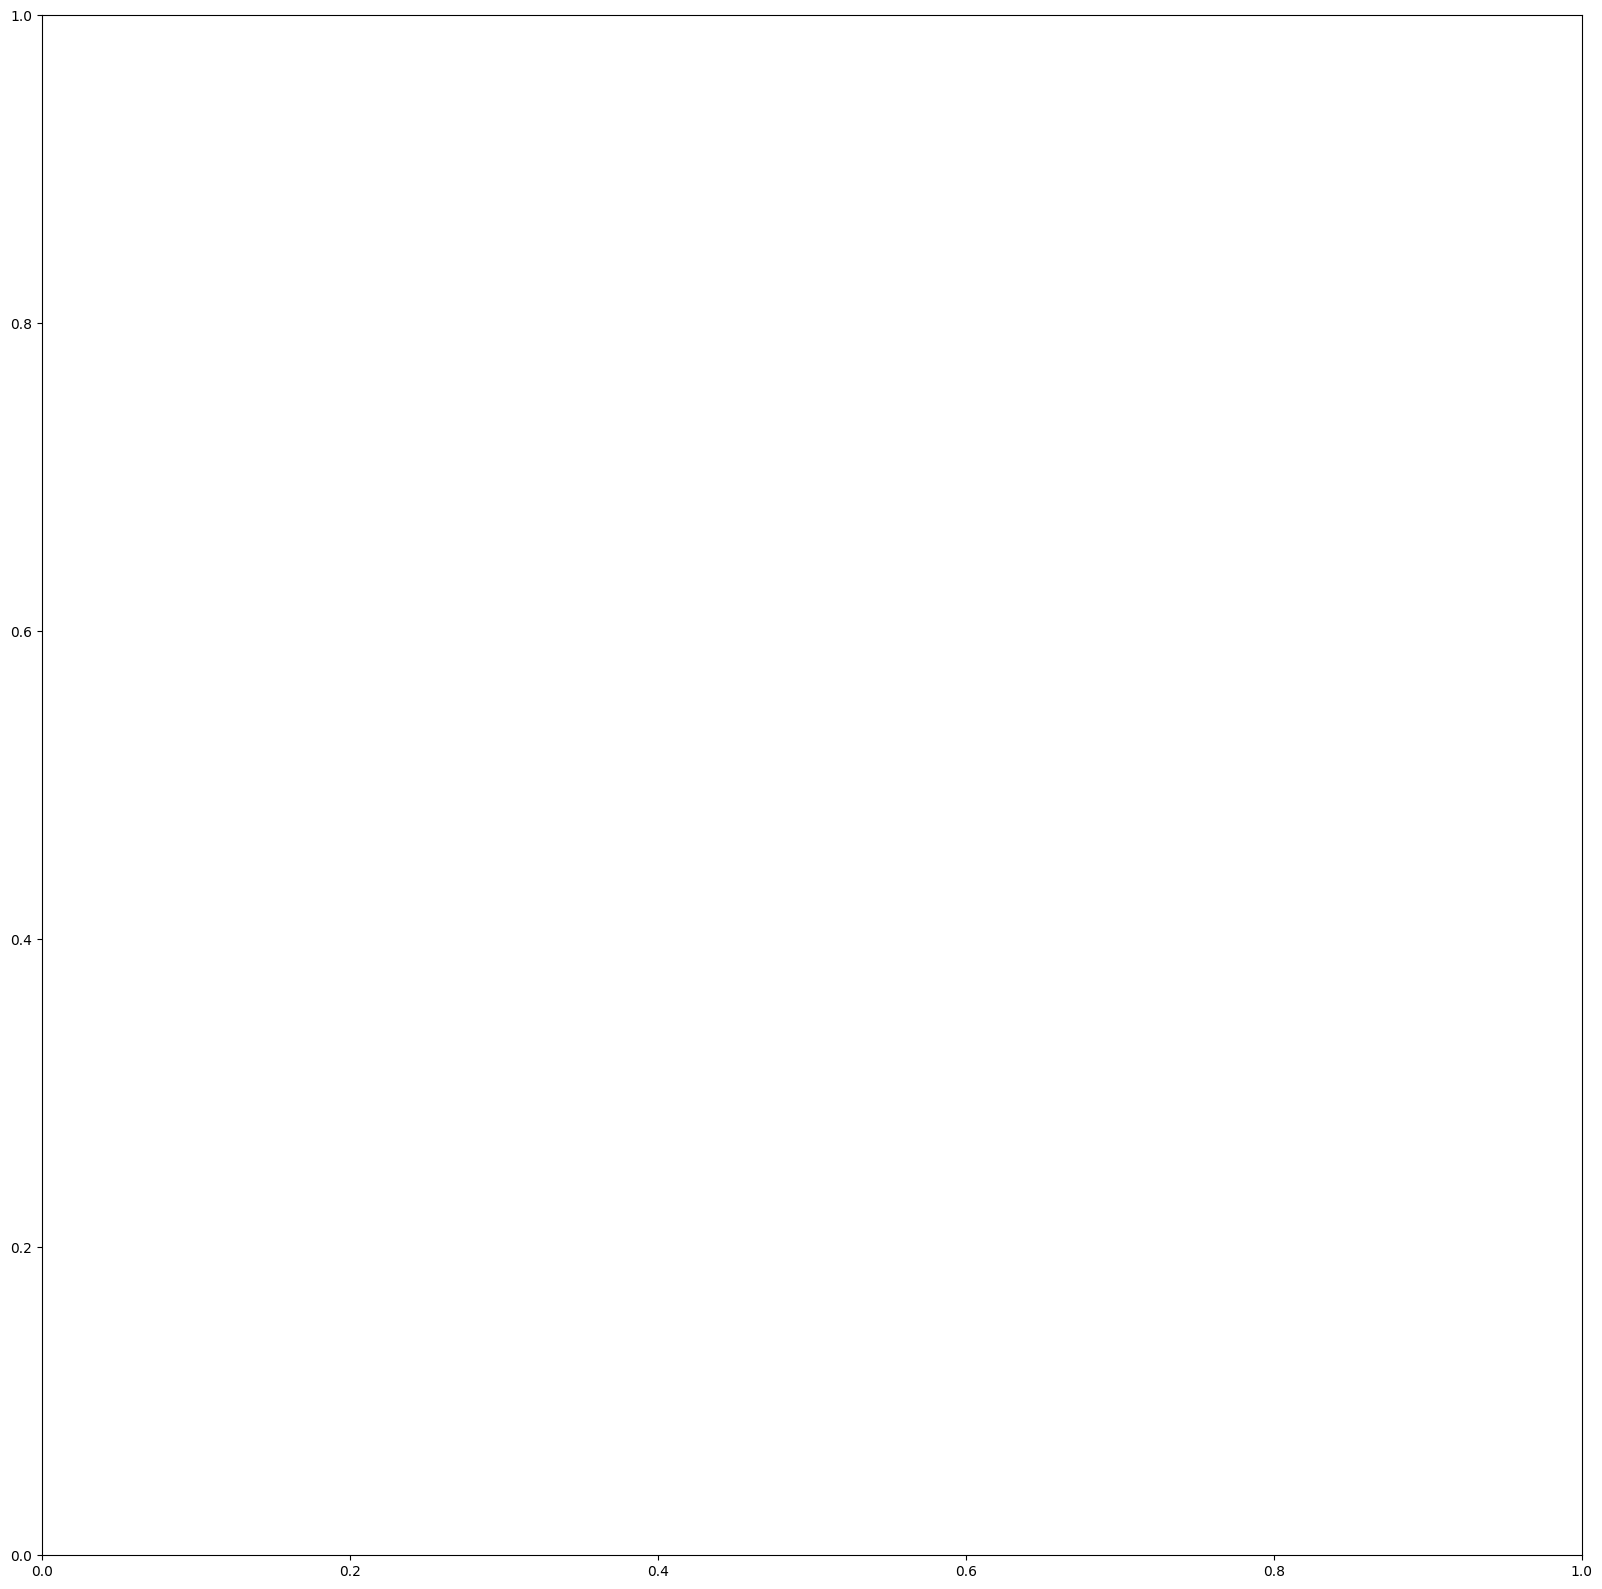

In [11]:
samShow(img)

## Example image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
dcmImg = '/content/drive/My Drive/dcm/SceneView.png'

In [2]:
def readImg_cv(filename):
    '''cv读图
    '''
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
def readImg_sitk(filename):
    '''sitk读图
    '''
    import SimpleITK as sitk
    image = sitk.ReadImage(filename)
    image = sitk.GetArrayFromImage(image)
    image = np.transpose(image, (1,2,0))
    return image

SyntaxError: ignored

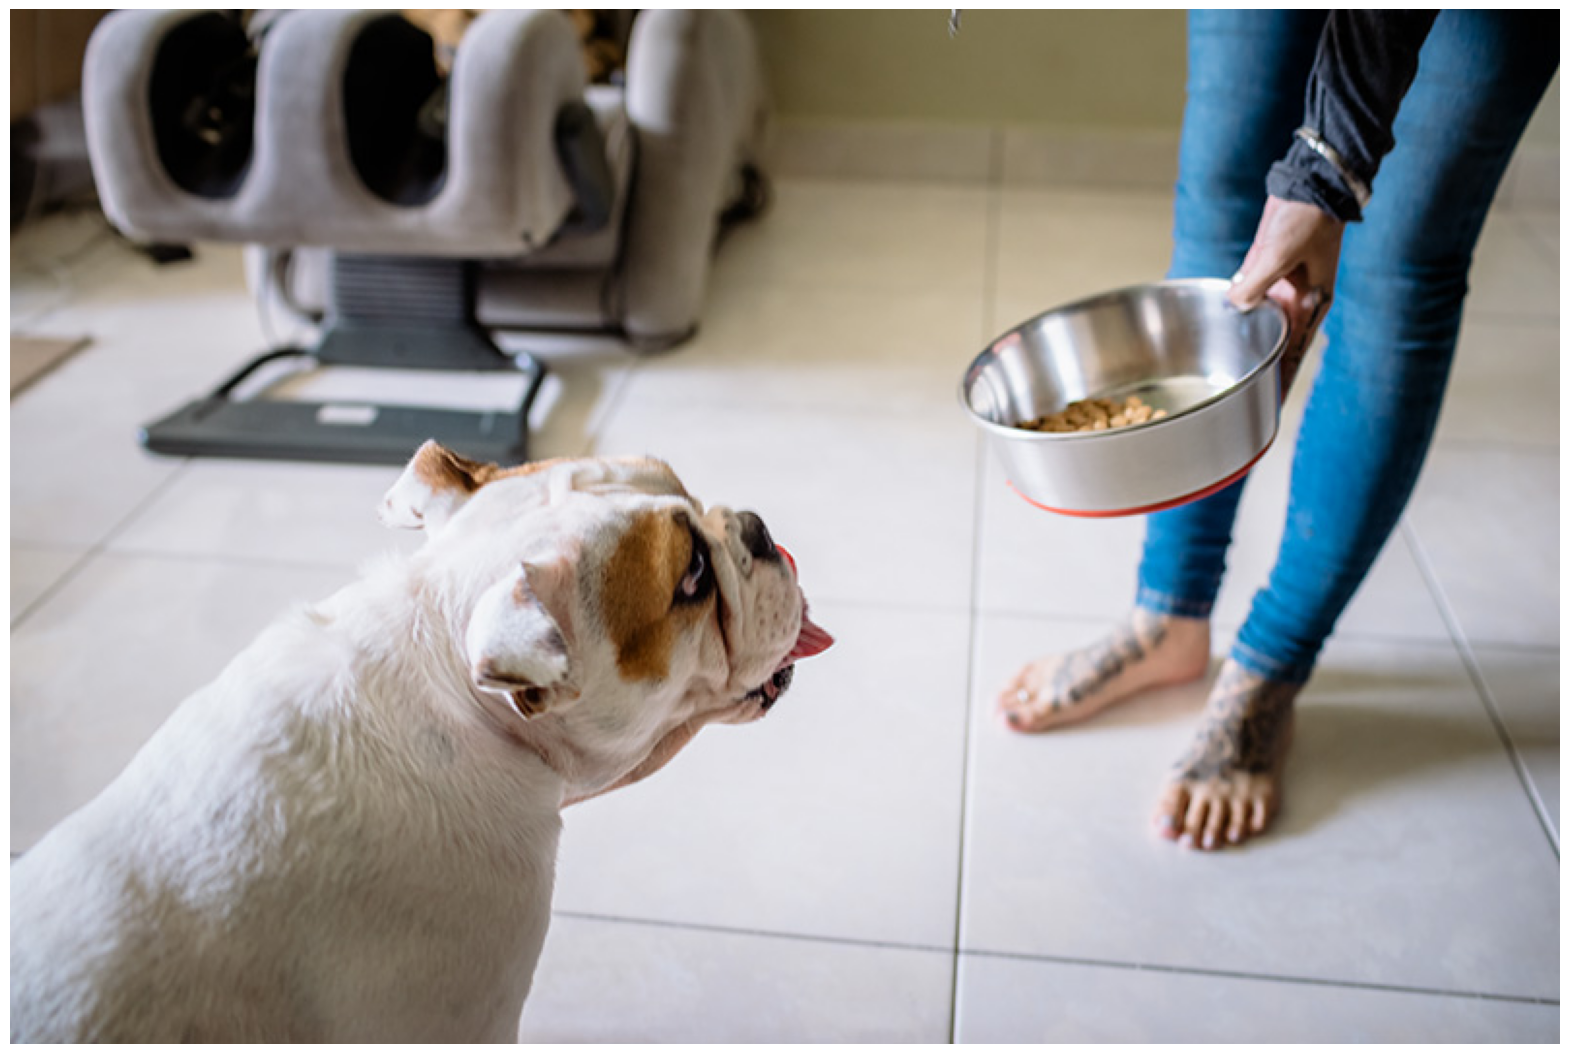

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

要运行自动掩码生成，请向 SamAutomaticMaskGenerator同学们将下面的路径设置为SAM检查点。建议在CUDA上运行并使用默认模型。


In [15]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

要生成掩码，只需运行 生成在图像上。

In [ ]:
masks = mask_generator.generate(image)

掩码生成返回掩码列表，其中每个掩码是包含关于掩码的各种数据的字典。这些键是：

    分割 ：遮罩
    面积 ：蒙版的面积（以像素为单位）
    bbox ：XYWH格式的蒙版边界框
    predicted_iou：模型自己对蒙版质量的预测
    point_coords：生成此掩码的采样输入点
    stability_score：掩模质量附加度量
    crop_box：用于生成此蒙版的XYWH格式的图像裁剪


In [ ]:
print(len(masks))
print(masks[0].keys())

19
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


显示图像上覆盖的所有蒙版。

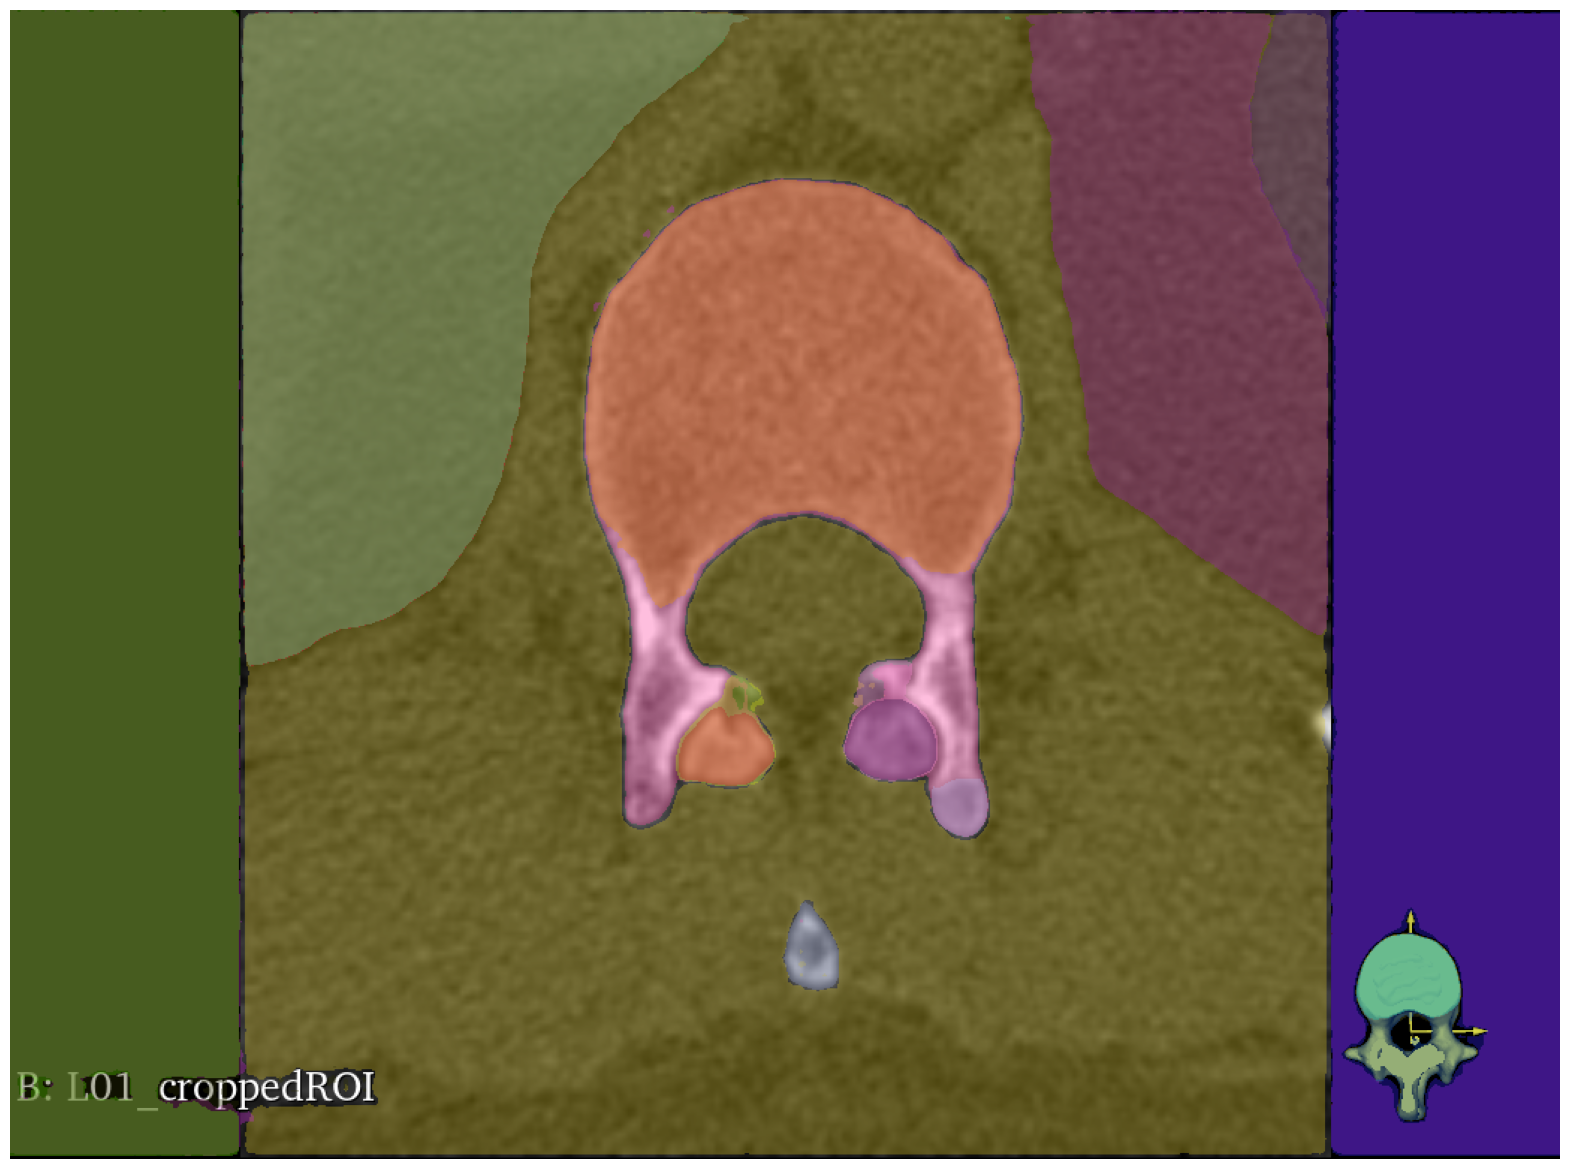

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

在自动掩模生成中有几个可调参数，用于控制采样点的密度以及用于去除低质量或重复掩模的阈值。此外，生成可以在图像的裁剪上自动运行，以在较小的对象上获得改进的性能，并且后处理可以去除杂散像素和孔。以下是对更多掩码进行采样的示例配置：

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

26

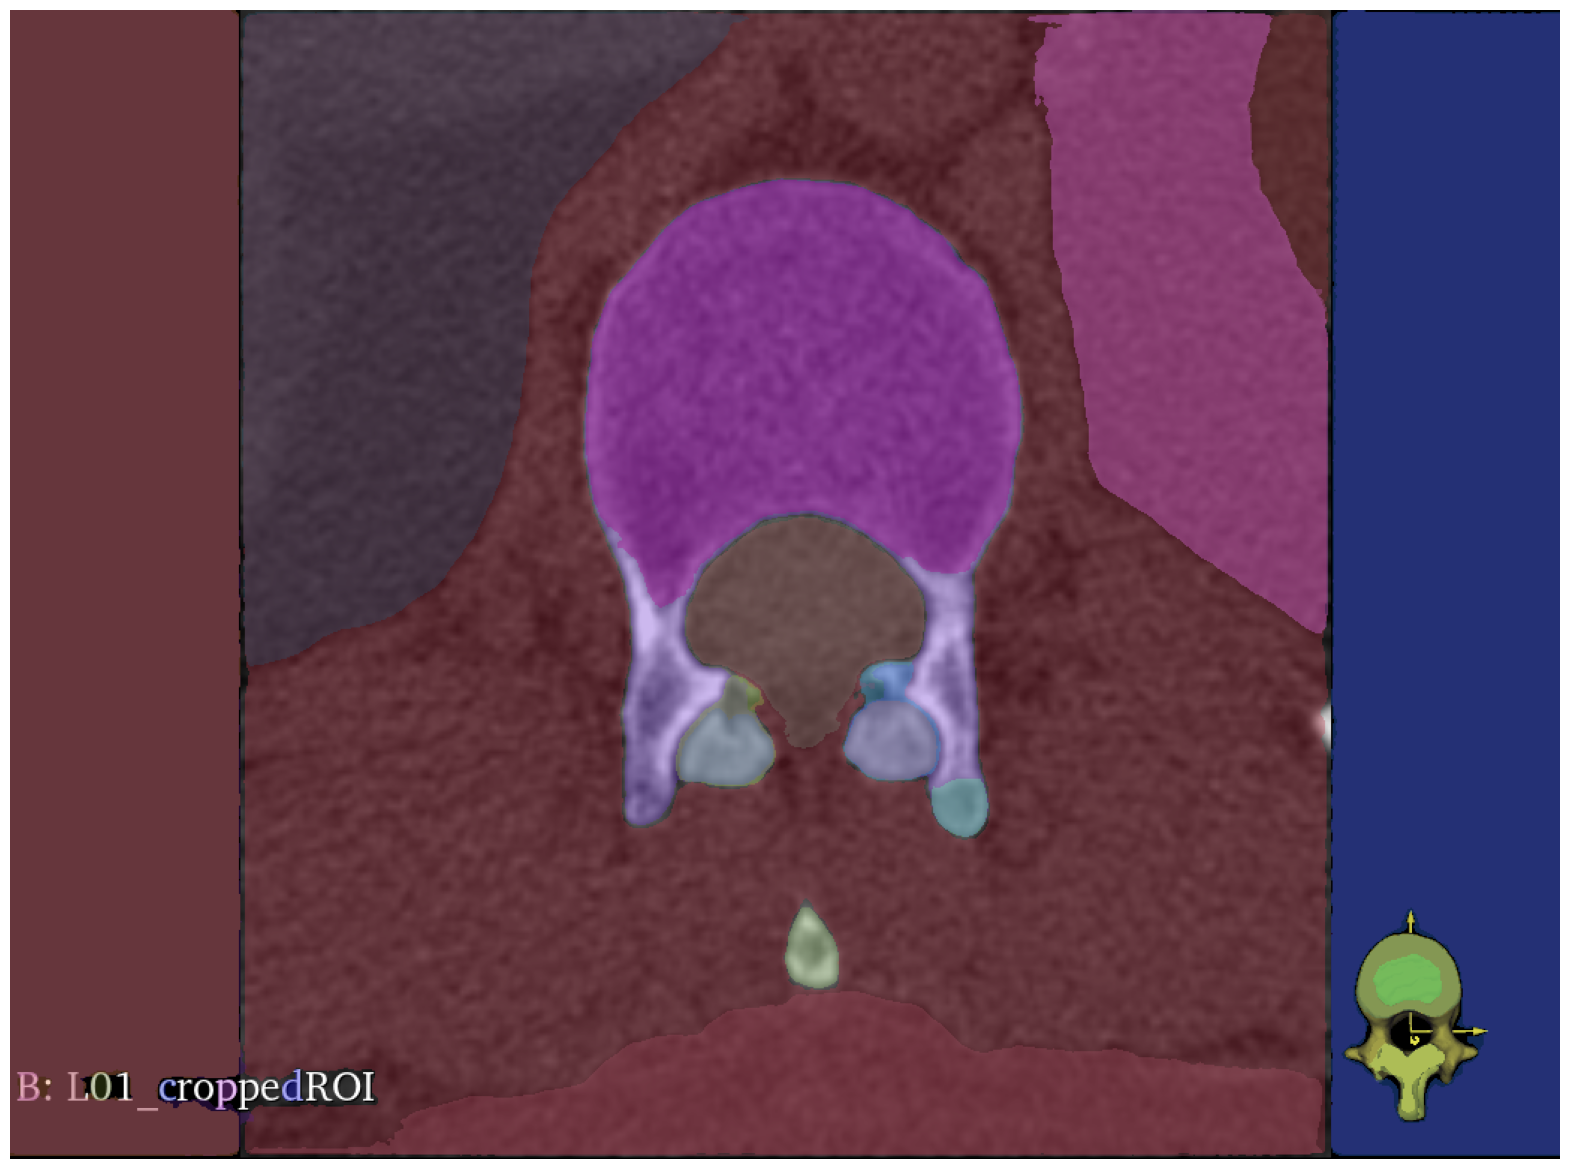

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 